# CNN 이미지 분류

- CIFAR-10 데이터셋

https://apply.gh.or.kr/sb/sr/sr7150/selectPbancRentHouseList.do

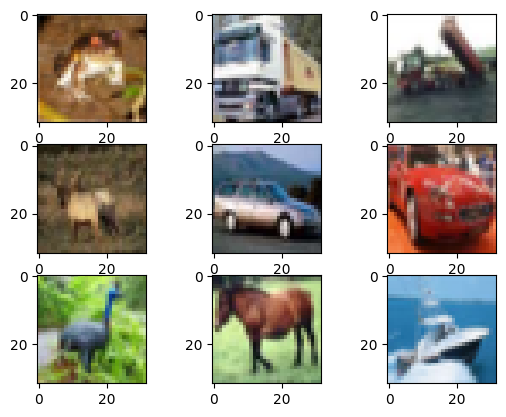

In [1]:
# 데이터 로드
import matplotlib.pyplot as plt
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor

train_data = CIFAR10(root='./', train=True, download=True, transform=ToTensor())
test_data = CIFAR10(root='./', train=False, download=True, transform=ToTensor())

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i][0].permute(1, 2, 0))

plt.show()

In [4]:
import torch
# 데이터셋 이미지의 평균과 표준편차 구하기
imgs = [item[0] for item in train_data]
imgs = torch.stack(imgs, dim=0).numpy()

# PyTorch 이미지 = 4차원 텐서 (batch_size, channel, height, width)
mean_r = imgs[:, 0, :, :].mean()
mean_g = imgs[:, 1, :, :].mean()
mean_b = imgs[:, 2, :, :].mean()

std_r = imgs[:, 0, :, :].std()
std_g = imgs[:, 1, :, :].std()
std_b = imgs[:, 2, :, :].std()

print(f"평균    > mean_r: {mean_r}, mean_g: {mean_g}, mean_b: {mean_b}")
print(f"표준편차> std_r : {std_r}, std_g : {std_g}, std_b : {std_b}")

평균    > mean_r: 0.4913996756076813, mean_g: 0.48215827345848083, mean_b: 0.4465312361717224
표준편차> std_r : 0.24703222513198853, std_g : 0.24348513782024384, std_b : 0.26158785820007324


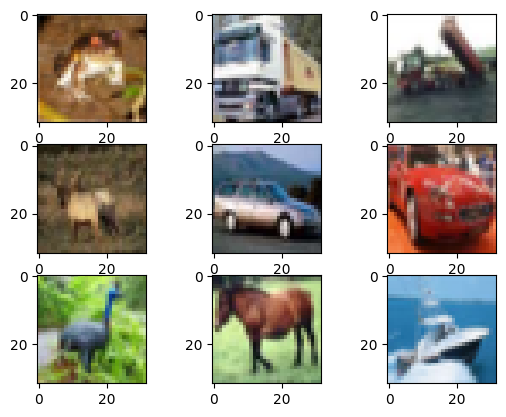

In [5]:

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data.data[i])

plt.show()

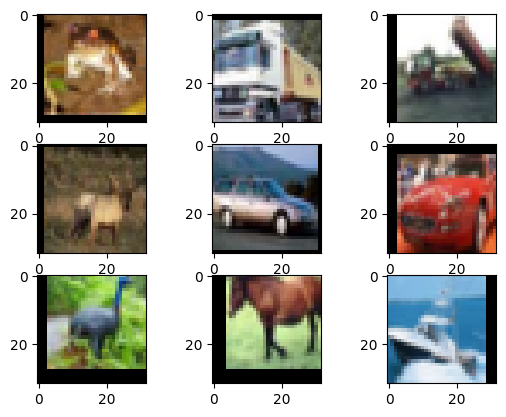

In [6]:
import torchvision.transforms as T
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomCrop

# 데이터 증강

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5)
])

train_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(train_data.data[i]))
plt.show()

평균    > mean_r : 0.4913996756076813, mean_g : 0.48215827345848083, mean_b : 0.4465312361717224<br>
표준편차>  std_r : 0.24703222513198853, std_g : 0.24348513782024384,  std_b : 0.26158785820007324

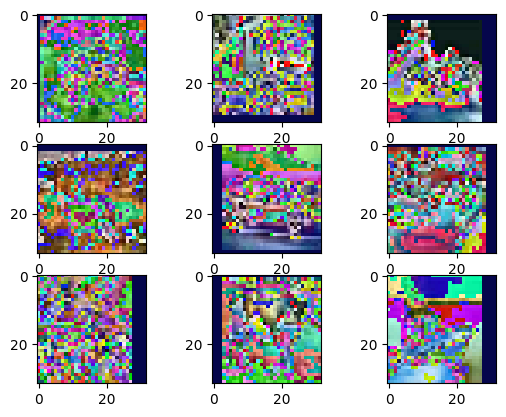

In [7]:
from torchvision.transforms import Normalize
# 정규화 : 우리가 보는 이미지는 0~255의 값을 가지지만, 모델은 0~1의 값을 가진다.
# 따라서 0~255의 값을 0~1의 값으로 변환해줘야 한다.

transforms = Compose([
    T.ToPILImage(),
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]),
    T.ToPILImage()
])

train_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(transforms(train_data.data[i]))
plt.show()

In [19]:
import torch.nn as nn

class CBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(CBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=hidden_dim,
            kernel_size=3,
            padding=1
        )

        self.conv2 = nn.Conv2d(
            in_channels=hidden_dim,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

In [20]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.block1 = CBlock(in_channels=3, out_channels=32, hidden_dim=16)
        self.block2 = CBlock(in_channels=32, out_channels=128, hidden_dim=64)
        self.block3 = CBlock(in_channels=128, out_channels=256, hidden_dim=128)
        
        self.fc1 = nn.Linear(in_features=4096, out_features=2048)
        self.fc2 = nn.Linear(in_features=2048, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = torch.flatten(x, start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [21]:
model = CNN(num_classes=10)
model

CNN(
  (block1): CBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): CBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): CBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=4096, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=256, bias=True)


In [ ]:
# DataLoader 준비
from torch.utils.data.dataloader import DataLoader

transforms = Compose([
    RandomCrop((32, 32), padding=4),
    RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261))
])

train_data = CIFAR10(root='./', train=True, download=True, transform=transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
from torch.optim.adam import Adam

# 학습
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN(num_classes=10)
model.to(device)

learning_rate = 1e-3
optim = Adam(model.parameters(), lr=learning_rate)

for epoch in range(100):
    for data, label in train_loader:
        optim.zero_grad()
        preds = model(data.to(device))

        loss = nn.CrossEntropyLoss()(preds, label.to(device))
        loss.backward()
        optim.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1} | loss: {loss.item():.4f}")

torch.save(model.state_dict(), "CIFAR10.pt")

TypeError: pic should be Tensor or ndarray. Got <class 'PIL.Image.Image'>.

In [ ]:
# 평가
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.load_state_dict(torch.load('CIFAR10.pt', map_location=device))
cnt_corr = 0

with torch.no_grad():
    for data, label in test_loader:
        output = model(data.to(device))
        preds = output.data.max(1)[1]
        corr = preds.eq(label.to(device).data).sum().item()
        cnt_corr += corr

    print(f"Accuracy: {cnt_corr / len(test_data)}") # Accuracy: 0.8007